# Setup

In [ ]:
# Import libraries
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (50, 3)

In [ ]:
# Define Base indices
D = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

In [ ]:
# Remove newlines in the file and return the resultant string
def getData(file_name):
  with open(file_name) as f:
    lines = f.readlines()
  lines = list(map(str.strip, lines))  # Remove trailing '\n'
  data = ''.join(lines)                # Join the string
  return data

In [ ]:
# Return the count of dinucleotides in given sequence
def getCount(d):
  count = dict()
  for i in range(0, len(d) - 1):
    if str(d[i : i + 2]) not in count:
      count[str(d[i : i + 2])] = 1
    else:  
      count[str(d[i : i + 2])] += 1
  return count

In [ ]:
# Return an array of index of valid sequences (not N) in format [start, end]
def getIndex(d):
  ret = []
  start = -1
  for i in range(0, len(d) - 1):
    if (d[i] != 'N'):
      if (start == -1):
        start = i
    else:
      if (start != -1):
        ret.append([start, i - 1])
        start = -1
  return np.array(ret)

In [ ]:
# Return data with no overlapping subsequence
def merge(data):
  if data.shape[0] == 0:
    return np.zeros(0)
  ret = []
  d = data[0]
  for i in range(data.shape[0]):
    if data[i, 0] <= d[1]:
      d[1] = d[1] if d[1] >= data[i, 1] else data[i, 1]
    else:
      ret.append(d)
      d = data[i]
  return np.array(ret)

In [ ]:
def getState(df, feature):
  subset = df[df['Type']==feature].drop(columns=['Type'])
  temp = subset.to_numpy()
  temp.sort(axis = 0)
  return merge(temp)

# Train Functions

In [ ]:
# Return the trained parameters
# Arguments:
#   data : a genetic sequence (ATCG)
#   index: an array of [start, end] specifying valid regions in data (i.e. no N)
#   state: an array of [start, end] specifying special regions in data (e.g. gene)
def train(data, index, state):
  a = np.zeros((2, 2))
  b = np.zeros((2, 4))
  print("Training", end = "")
  for i in range(index.shape[0]):
    print(".", end = "")
    updateCount(
        data[index[i][0] : index[i][1] + 1], 
        state[np.logical_and(state[:, 1] >= index[i][0], state[:, 0] <= index[i][1])] - index[i][0],
        a, 
        b)
  print(" completed")

  b = b / np.sum(b, axis = 1)[:, np.newaxis]
  a = a / np.sum(a, axis = 1)[:, np.newaxis]
  return {"a": a, "b": b}

In [ ]:
# Update the count of a and b
# Arguments:
#   data : a genetic sequence
#   state: an array of [start, end] specifying special regions in data (e.g. gene)
#   a    : transition matrix
#   b    : emission matrix
def updateCount(data, state, a, b):
  K = state.shape[0]
  j = 0 if K > 0 else -1  # if j = -1, no special region available
  for i in range(len(data)):
    if (j == -1):
      b[0, D[data[i]]] += 1
      if (i - 1 >= 0):
        if (K > 0 and inRange(i - 1, state[K - 1])):
          a[1, 0] += 1
        else:
          a[0, 0] += 1
    else:
      if (inRange(i, state[j])):
        b[1, D[data[i]]] += 1
        if (i - 1 >= 0):
          if (K > 0 and inRange(i - 1, state[j])):
            a[1, 1] += 1
          else:
            a[0, 1] += 1
      else:
        b[0, D[data[i]]] += 1
        if (i - 1 >= 0):
          if (K > 0 and inRange(i - 1, state[j])):
            a[1, 0] += 1
          else:
            a[0, 0] += 1
    
    # Update j to make sure j is the current index of special region
    if (j != -1 and i == state[j][1]):
      j += 1
      if (j == K):
        j = -1

In [ ]:
def inRange(idx, r):
  return idx >= r[0] and idx <= r[1]

# Test Functions

In [ ]:
# Metric of accuracy
metric = ([['True Positive', 'False Positive'], ['False Negative', 'True Negative']])

In [ ]:
# Return most probable hidden state sequence
def viterbi(data, a, b):
  N = len(data)               # Length of sequence
  K = 2                       # Number of States 
  V = np.zeros((K, N + 1))    # Joint Probability Tensor
  P = np.zeros((K, N + 1))    # Pointer Tensor
  V.fill(-float('inf'))
  P.fill(-float('inf'))

  # Initialize start state = State 0
  V[:, 0] = np.log(a[0])

  # Iterative Dynamic Programming
  for i in range(1, N + 1):
    for j in range(0, K):
      for k in range(0, K):
        p = V[k, i - 1] + np.log(a[k, j] * b[j, D[data[i - 1]]])
        if (p > V[j][i]):
          V[j, i] = p
          P[j, i] = k
  
  # # Find the max sequence end
  m = 1 if V[1, N] > V[0, N] else 0
  res = np.zeros((N,), dtype = int)
  res[N - 1] = m

  # Backtrace the sequence
  for i in range(N - 2, -1, -1):
    res[i] = P[res[i + 1], i + 1]
  return res

In [ ]:
def analyze(accuracy):
  print(accuracy)

  precision = accuracy[0, 0] / np.sum(accuracy[0])
  recall = accuracy[0, 0] / np.sum(accuracy[: , 0])
  f1_score = 0 if precision == 0 or recall == 0 else 2 * precision * recall / (precision + recall)
  overall_accuracy = (accuracy[0, 0] + accuracy[1, 1]) / accuracy.sum()

  print("Precision: " + str(round(precision, 4)))
  print("Recall: " + str(round(recall, 4)))
  print("F1 Score: " + str(round(f1_score, 4)))
  print("Accuracy: " + str(round(overall_accuracy, 4)))

In [ ]:
def test(data, index, state, a, b, output = False):
  accuracy = np.zeros((2, 2))
  print("Testing", end = "")
  for i in range(index.shape[0]):
    print(".", end = "")
    v = viterbi(data[index[i][0] : index[i][1] + 1], a, b)
    substate = state[np.logical_and(state[:, 1] >= index[i][0], state[:, 0] <= index[i][1])]
    updateAccuracy(
        v,
        substate - index[i][0],
        accuracy
        )
    if (output):
      # Plot Actual Data
      for s in substate:
        start = max(s[0], index[i][0])
        end = min(s[1], index[i][1]) + 1
        plt.plot(range(start, end), np.ones((end - start)), color = "blue", alpha= 0.5,  linewidth = 1.5)

      # Plot Prediction
      k = -1
      for j in range(v.shape[0]):
        if (v[j] == 0):
          if (k != -1):
            start = k + index[i][0]
            end = j + index[i][0] + 1
            plt.plot(range(start, end), np.zeros((end - start)), color = "red", alpha = 0.5, linewidth = 1.5)
            k = -1
        else:
          if (k == -1):
            k = j
      # if (i == 5):
      #   break
  plt.ylim([-1, 2])          
  plt.show()
  print(" completed")
  analyze(accuracy)

Testing........................

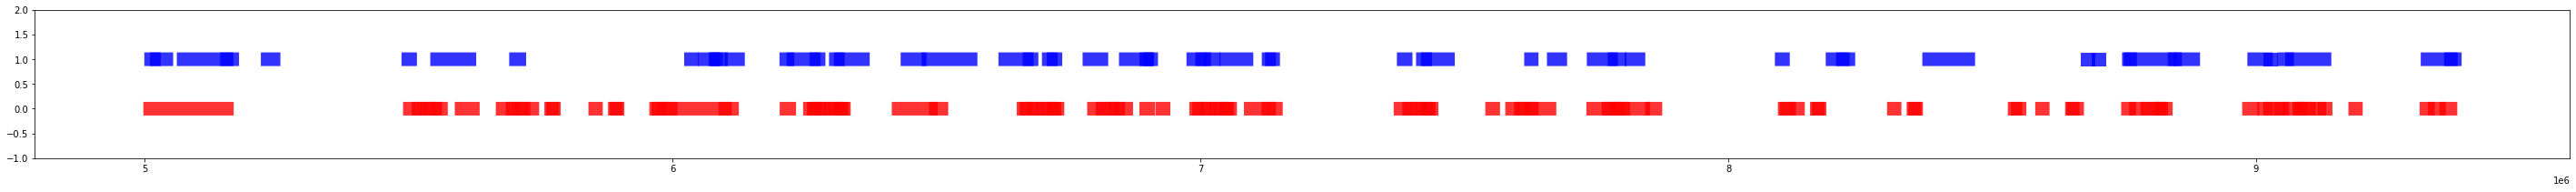

 completed
[[ 550932.  602260.]
 [ 821385. 1242565.]]
Precision: 0.4777
Recall: 0.4015
F1 Score: 0.4363
Accuracy: 0.5575


In [ ]:
test(training_set, training_index, training_state, param['a'], param['b'], True)

Testing.........................................................................................

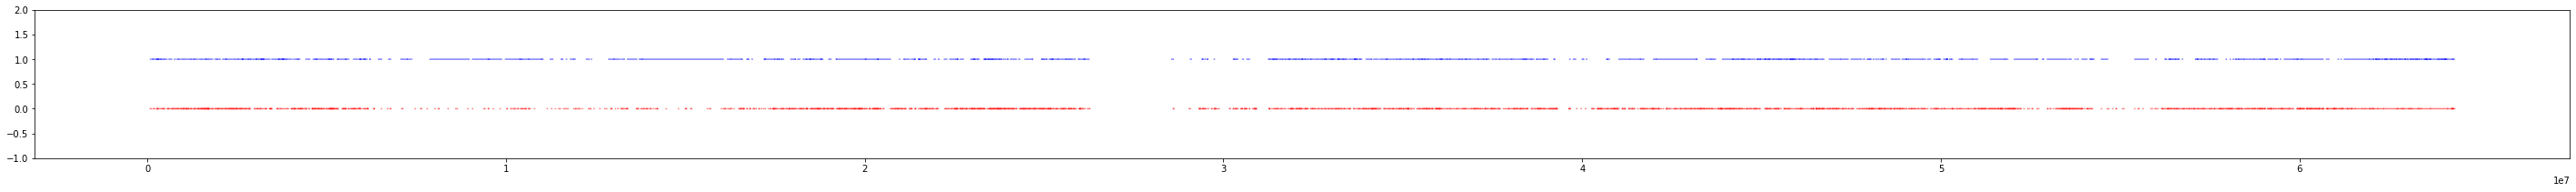

 completed
[[16577475. 10970763.]
 [13679677. 22716342.]]
Precision: 0.6018
Recall: 0.5479
F1 Score: 0.5736
Accuracy: 0.6145


In [ ]:
test(testing_set, testing_index, testing_state, param['a'], param['b'], True)

In [ ]:
def updateAccuracy(v, state, accuracy):
  K = state.shape[0]
  j = 0 if K > 0 else -1
  for i in range(v.shape[0]):
    if j == -1:
      if (v[i] == 0):
        accuracy[1, 1] += 1
      else:
        accuracy[0, 1] += 1
    else:
      if (v[i] == 0):
        if (inRange(i, state[j])):
          accuracy[1, 1] += 1
        else:
          accuracy[1, 0] += 1
      else:
        if (inRange(i, state[j])):
          accuracy[0, 0] += 1
        else:
          accuracy[0, 1] += 1
    if j != -1 and i == state[j][1]:
      j += 1
      if (j == K):
        j = -1

In [ ]:
def baseline_test(data, index, state):
  a = np.zeros((2, 2))
  b = np.zeros((2, 4))
  print("Training", end = "")
  for i in range(index.shape[0]):
    print(".", end = "")
    updateCount(
        data[index[i][0] : index[i][1] + 1], 
        state[np.logical_and(state[:, 1] >= index[i][0], state[:, 0] <= index[i][1])] - index[i][0],
        a, 
        b)
  print(" completed")
  temp = np.sum(b, axis = 1)
  print("Baseline Accuracy: " + str(round(temp[0] / np.sum(temp), 4)))

# Main

In [ ]:
# Feature References for Type
features = ['gene', 'exon', 'transcript', 'CDS', 'UTR', 'start_codon', 'stop_codon']

In [ ]:
# Import data (chr21.csv and sequence_fasta.txt)
uploaded = files.upload()
del uploaded

Saving chr20.csv to chr20.csv
Saving chr20.txt to chr20.txt
Saving chr21.csv to chr21.csv
Saving chr21.txt to chr21.txt


TODO:

1) Make a plot the genes versus predicted genes


In [ ]:
# Precompute resources for training and testing

# Datasets
training_set = getData('chr21.txt')
testing_set = getData('chr20.txt')

# GTF Annotations
training_df = pd.read_csv('chr21.csv')
testing_df = pd.read_csv('chr20.csv')

# Indices
training_index = getIndex(training_set)
testing_index = getIndex(testing_set)

# Gene State
training_state = getState(training_df, 'gene')
testing_state = getState(testing_df, 'gene')

In [ ]:
baseline_test(testing_set, testing_index, testing_state)

Training......................................................................................... completed
Baseline Accuracy: 0.4367


In [ ]:
param = train(training_set, training_index, training_state)

Training........................ completed


Testing......

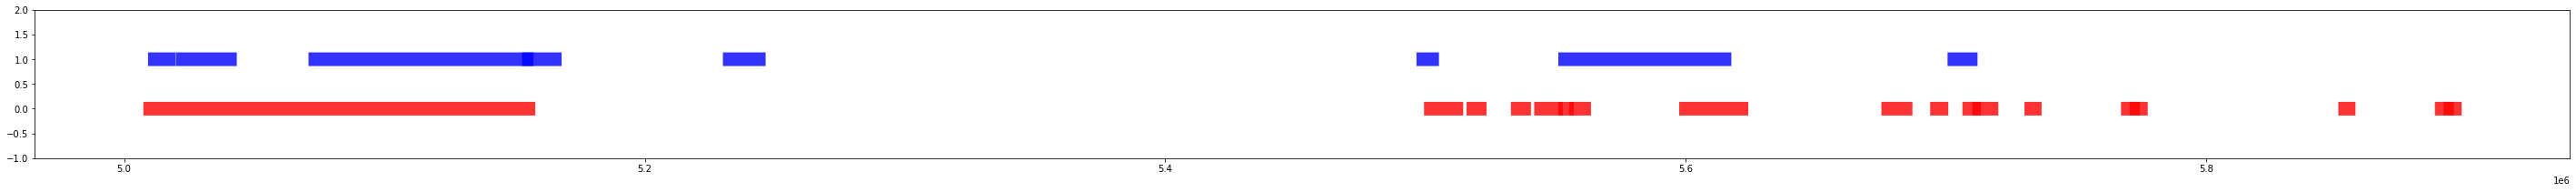

 completed
[[131894.  92709.]
 [ 64939. 367051.]]
Precision: 0.5872
Recall: 0.6701
F1 Score: 0.6259
Accuracy: 0.7599


In [ ]:
test(training_set, training_index, training_state, param['a'], param['b'], True)

In [ ]:
test(testing_set, testing_index, testing_state, param['a'], param['b'], True)

In [ ]:
# Warning: this takes 15 minutes
def main():
  print('This is a hidden markov model that models the human genome sequencing.')
  print('The model trains on chromosome 21 and its accuracy is being tested on chromosome 20')
  param = train(training_set, training_index, training_state)
  # print(param['a'])
  # print(param['b'])
  test(testing_set, testing_index, testing_state, param['a'], param['b'], True)
  print('\n')

This is a hidden markov model that models the human genome sequencing.
The model trains on chromosome 21 and its accuracy is being tested on chromosome 
Training........................ completed
Testing.........................................................................................

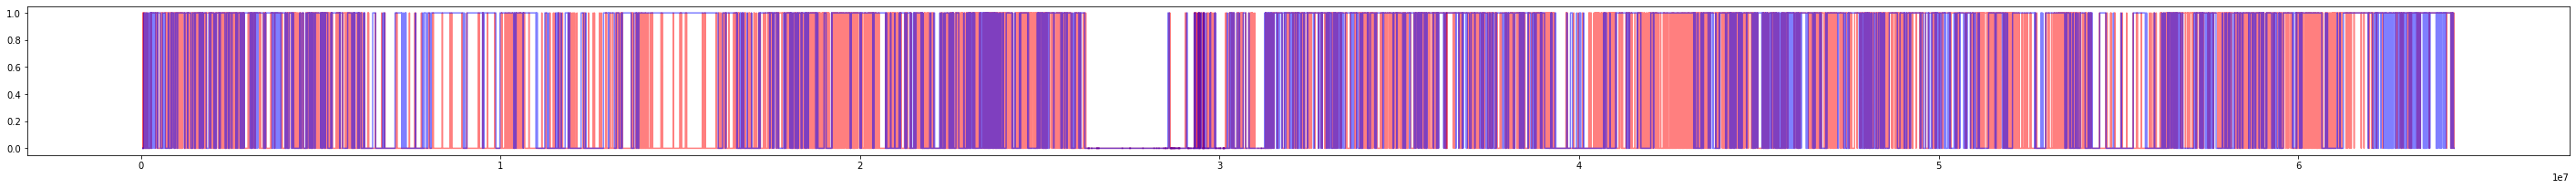

 completed
[[16577475. 10970763.]
 [13679677. 22716342.]]
Precision: 0.6018
Recall: 0.5479
F1 Score: 0.5736
Accuracy: 0.6145




In [ ]:
main()

# Result

## Training Result

```
[[9.99963052e-01 3.69475868e-05]
 [1.76096479e-05 9.99982390e-01]]
[[0.28708164 0.29674664 0.21116052 0.20501121]
 [0.25873412 0.27473297 0.2353693  0.23116361]]
```

## Testing Result

Test on Chromosome 21 (the training set)

```
[[ 550932.  602260.]
 [ 821385. 1242565.]]
Precision: 0.4777
Recall: 0.4015
F1 Score: 0.4363
Accuracy: 0.5575
Baseline Accuracy: 0.6646
```

Test on Chromosome 20 (the testing set)

```
[[16577475. 10970763.]
 [13679677. 22716342.]]
Precision: 0.6018
Recall: 0.5479
F1 Score: 0.5736
Accuracy: 0.6145
Baseline Accuracy: 0.4367
```

# Future Proposal

Our implementation could be improved further by extending the current model of dinucleotides to codons. 

Details to be considered:
- Type of emissions: remain 4 (ATCG)
- Transition: how??